In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns
import funs_project as fp

# Optimisation

In [2]:
ACTORNAME = "Gorssel"

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

## Reading

In [4]:
cases = fp.the_cases(ACTORNAME)

In [5]:
policies = fp.crude_policy_selection(ACTORNAME, 6)

In [6]:
policies = policies.sort_values(by="scenario")
policies

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs,scenario
5,0,0,0,1,1,1,2,3,0,0,6,1,4,0.000000e+00,0.000000,8.453408e+06,3
17,0,0,0,1,1,1,2,5,0,0,3,4,1,7.963552e+06,0.000600,1.106922e+07,4
16,0,0,0,1,1,1,2,4,0,0,3,6,5,1.363324e+07,0.000984,9.695982e+06,4
14,0,0,0,1,1,1,3,3,0,0,5,1,5,4.956868e+07,0.002640,8.457116e+06,4
12,0,0,0,1,1,1,3,1,0,0,9,6,4,9.451100e+07,0.004658,6.328075e+06,4
9,0,0,0,1,0,1,1,8,0,0,10,4,1,0.000000e+00,0.000000,1.610892e+07,4
13,0,0,0,1,1,1,0,7,0,0,10,4,1,8.184661e+05,0.000448,1.426165e+07,4
22,0,0,0,1,1,1,3,8,0,0,2,5,3,0.000000e+00,0.000000,1.610892e+07,5
23,0,0,0,1,1,1,2,4,0,0,3,6,3,1.791298e+07,0.000978,9.695980e+06,5
19,0,0,0,1,1,1,2,5,0,0,7,7,3,1.046604e+07,0.000596,1.106922e+07,5


In [7]:
policies.iloc[:, 0:13]

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
5,0,0,0,1,1,1,2,3,0,0,6,1,4
17,0,0,0,1,1,1,2,5,0,0,3,4,1
16,0,0,0,1,1,1,2,4,0,0,3,6,5
14,0,0,0,1,1,1,3,3,0,0,5,1,5
12,0,0,0,1,1,1,3,1,0,0,9,6,4
9,0,0,0,1,0,1,1,8,0,0,10,4,1
13,0,0,0,1,1,1,0,7,0,0,10,4,1
22,0,0,0,1,1,1,3,8,0,0,2,5,3
23,0,0,0,1,1,1,2,4,0,0,3,6,3
19,0,0,0,1,1,1,2,5,0,0,7,7,3


Below we plot per scenario 

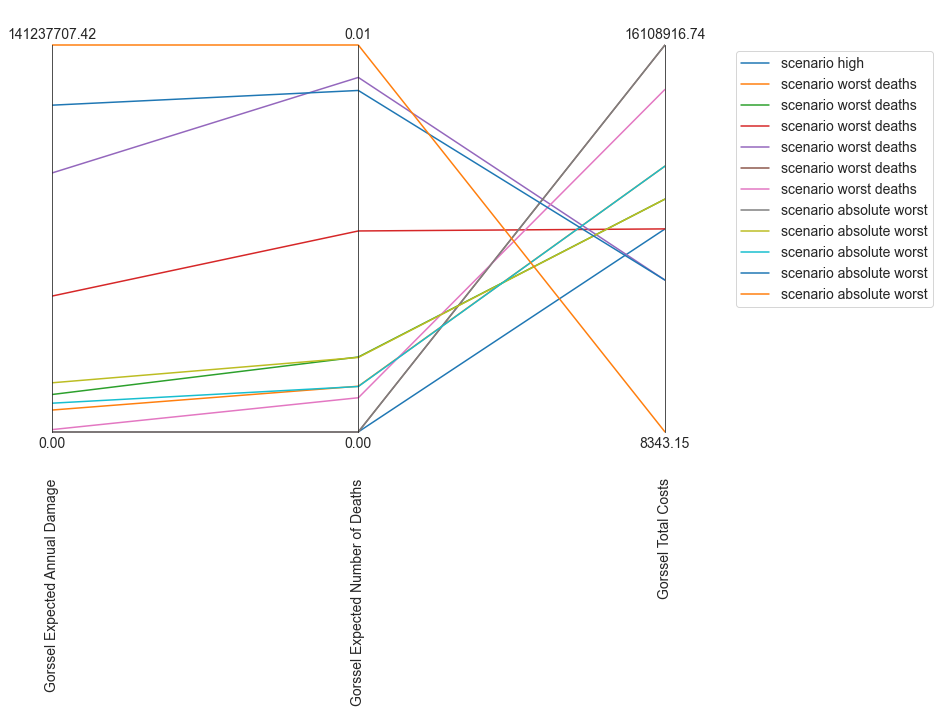

In [43]:
colors = iter(sns.color_palette(n_colors = 12))
limits = parcoords.get_limits(policies.iloc[:, 13:16])

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for index, row in policies.iterrows():
    color = next(colors)
    paraxes.plot(row, label=f'scenario {cases[row.scenario]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (10,10)

plt.show()


# Reevaluate under deep uncertainty

## Reading

In [9]:
n_scenarios = 1000

In [10]:
du_experiments, du_outcomes = load_results("simulation/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

### Keep only the DU experiments and outcomes that are in POLICIES

In [11]:
du_outcomes_df = pd.DataFrame.from_dict(du_outcomes)
merged_du = pd.concat([du_experiments, du_outcomes_df], axis=1)
merged_du

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,A.0_ID flood wave shape,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Difference in Expected Annual Damage Gorssel-Deventer,Difference in Expected Number of Deaths Gorssel-Deventer,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,44.0,...,0.0,5.0,0,scenario best option 0,dikesnet,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,98.0,...,0.0,5.0,1,scenario best option 0,dikesnet,-6.970114,-1.026833e-09,7.020229e+05,0.000103,1.692349e+01
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,105.0,...,0.0,5.0,2,scenario best option 0,dikesnet,-916.212933,-1.464780e-07,9.228005e+07,0.014753,3.962356e+03
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,74.0,...,0.0,5.0,3,scenario best option 0,dikesnet,-1267.365657,-1.632675e-07,1.276478e+08,0.016444,4.662597e+03
4,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,83.0,...,0.0,5.0,4,scenario best option 0,dikesnet,-901.134603,-2.777079e-07,0.000000e+00,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,43.0,...,4.0,7.0,995,scenario absolute worst option 8,dikesnet,-282.122533,-4.646022e-08,0.000000e+00,0.000000,6.320800e+06
26996,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,76.0,...,4.0,7.0,996,scenario absolute worst option 8,dikesnet,-950.101558,-7.900394e-08,0.000000e+00,0.000000,6.320800e+06
26997,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,23.0,...,4.0,7.0,997,scenario absolute worst option 8,dikesnet,-132.809457,-7.593880e-09,1.337644e+07,0.000765,6.321765e+06
26998,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,123.0,...,4.0,7.0,998,scenario absolute worst option 8,dikesnet,-156.411343,-1.057876e-08,1.575359e+07,0.001065,6.322181e+06


In [12]:
#now compare the policies in merged_du to the policies in 'policies' 
policies_policy_df = policies.iloc[:, 0:13]
DU_policy_selected_df = pd.merge(policies_policy_df, merged_du, how = "inner")
DU_policy_selected_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,...,discount rate 1,discount rate 2,scenario,policy,model,Difference in Expected Annual Damage Gorssel-Deventer,Difference in Expected Number of Deaths Gorssel-Deventer,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs
0,0,0,0,1,1,1,2,3,0,0,...,4.5,3.5,0,scenario high option 0,dikesnet,0.000000,0.000000e+00,0.000000e+00,0.000000,8.453408e+06
1,0,0,0,1,1,1,2,3,0,0,...,1.5,1.5,1,scenario high option 0,dikesnet,0.000000,0.000000e+00,0.000000e+00,0.000000,8.453408e+06
2,0,0,0,1,1,1,2,3,0,0,...,4.5,1.5,2,scenario high option 0,dikesnet,-429.919800,-3.229530e-08,4.330109e+07,0.003253,8.456369e+06
3,0,0,0,1,1,1,2,3,0,0,...,1.5,2.5,3,scenario high option 0,dikesnet,-504.805136,-3.154115e-08,5.084347e+07,0.003177,8.456329e+06
4,0,0,0,1,1,1,2,3,0,0,...,1.5,4.5,4,scenario high option 0,dikesnet,-372.147151,-5.207202e-08,0.000000e+00,0.000000,8.453408e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,1,1,1,3,0,0,0,...,2.5,1.5,995,scenario absolute worst option 2,dikesnet,-17.532616,-2.927639e-09,0.000000e+00,0.000000,0.000000e+00
11996,0,0,0,1,1,1,3,0,0,0,...,3.5,3.5,996,scenario absolute worst option 2,dikesnet,-353.574932,-2.857788e-08,3.772080e+06,0.000232,2.673235e+02
11997,0,0,0,1,1,1,3,0,0,0,...,4.5,1.5,997,scenario absolute worst option 2,dikesnet,-170.675517,-9.564700e-09,1.719027e+07,0.000963,1.253614e+03
11998,0,0,0,1,1,1,3,0,0,0,...,2.5,4.5,998,scenario absolute worst option 2,dikesnet,-408.674756,-2.621546e-08,4.116131e+07,0.002640,3.708277e+03


#### rewrite du_experiments and du_outcomes with the filtered version

In [13]:
du_outcomes_policy_df = DU_policy_selected_df[DU_policy_selected_df.columns[-3:]].copy()
du_experiments = DU_policy_selected_df[DU_policy_selected_df.columns[0:55]].copy()
du_outcomes = du_outcomes_policy_df.to_dict('series')

## Regret
Comparing alternatives
"With a regret view, a decision maker wants to minimize the regret of choosing incorrectly, where regret is the loss in performance. This regret could be the cost of assuming the wrong future scenario or the cost of choosing the wrong alternative. In the first case, maximum regret of an alternative is the difference between its performances in the best estimate future scenario and in the scenario where it shows the worst performance, for example, as applied by Kasprzyk et al. (2013). In the second case, the regret of an alternative in a certain future scenario is the difference between its performance and the best-performing alternative, as proposed by Savage (1951). Maximum regret of an alternative is its highest regret achieved over all future scenarios. In both regret cases, the alternative with the smallest maximum regret is the most robust."

https://link.springer.com/article/10.1007/s13595-017-0641-2

In [14]:
outcomekeys = list(du_outcomes.keys())
outcomekeys

['Gorssel Expected Annual Damage',
 'Gorssel Expected Number of Deaths',
 'Gorssel Total Costs']

In [15]:
DAMAGE = outcomekeys[0]
DEATHS = outcomekeys[1]
COSTS = outcomekeys[2]

Regret calculation based on assignments

In [16]:
overall_scores = {}
regret = []
for scenario in du_experiments.scenario.unique():
    logical = du_experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in du_outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = du_experiments[du_experiments.scenario==scenario]
    best = temp_results.min()
    scenario_regret = temp_results - best
    scenario_regret['policy'] = temp_experiments.policy.values
    regret.append(scenario_regret)

In [17]:
temp_experiments.policy.values

['scenario high option 0', 'scenario worst deaths option 8', 'scenario worst deaths option 7', 'scenario worst deaths option 5', 'scenario worst deaths option 3', ..., 'scenario absolute worst option 4', 'scenario absolute worst option 5', 'scenario absolute worst option 1', 'scenario absolute worst option 8', 'scenario absolute worst option 2']
Length: 12
Categories (27, object): ['scenario absolute worst option 0', 'scenario absolute worst option 1', 'scenario absolute worst option 2', 'scenario absolute worst option 3', ..., 'scenario worst deaths option 5', 'scenario worst deaths option 6', 'scenario worst deaths option 7', 'scenario worst deaths option 8']

In [18]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max().dropna()

In [19]:
maxregret

,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs
policy,,,
scenario absolute worst option 1,7.138509e+07,0.004196,1.106877e+07
scenario absolute worst option 2,1.610023e+08,0.005664,0.000000e+00
scenario absolute worst option 4,0.000000e+00,0.000000,1.610892e+07
scenario absolute worst option 5,9.251482e+07,0.005281,9.695195e+06
scenario absolute worst option 8,1.594152e+08,0.005664,6.320800e+06
scenario high option 0,1.236721e+08,0.005958,8.453408e+06
scenario worst deaths option 0,8.355830e+06,0.006053,1.610892e+07
scenario worst deaths option 3,1.594152e+08,0.005664,6.320800e+06
scenario worst deaths option 4,2.953539e+07,0.020756,1.426165e+07


#### renaming policies for legend
rename policy names to things that will stick and we'll remember
In the order that they are above, replace with 
G_0, G_1, ...  G_10, G_11,

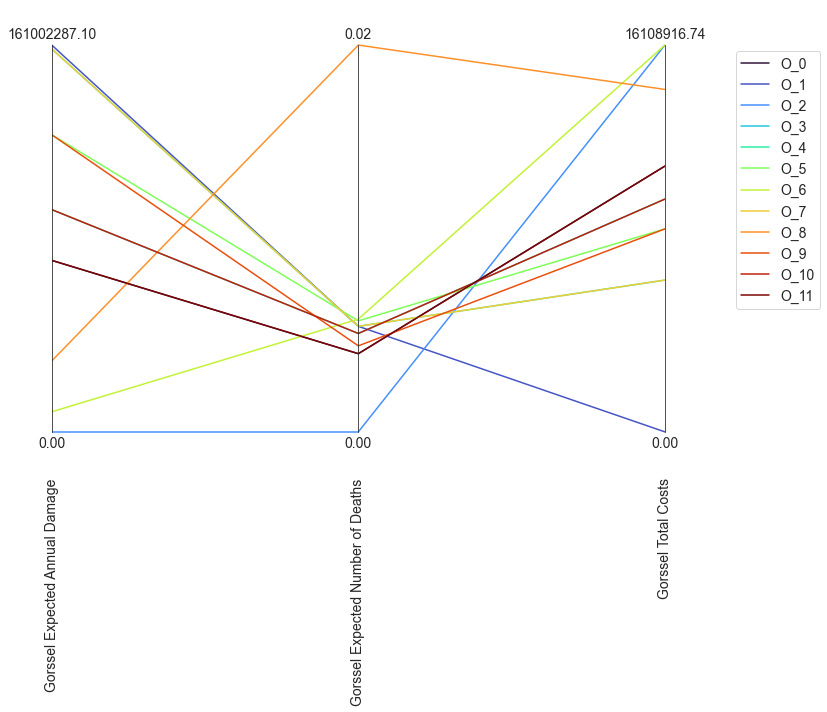

In [59]:
from matplotlib import cm

limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)


cmap = cm.get_cmap('turbo', maxregret.shape[0])
i=0
for index, row in maxregret.iterrows():
    name = 'O_' + str(i)
    paraxes.plot(row, color=cmap.colors[i], label=name)
    i+=1
    
paraxes.legend()
plt.savefig("../../report/figures/results/regret_figure"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

## Satisficing
Performance threshold
"seeks a decision alternative that meets his or her performance requirements over the range of plausible future scenarios. "

In [21]:
satisfycing_df = policies.copy()
satisfycing_df.drop_duplicates(inplace=True)
#satisfycing_df

In [22]:
belowtresh_df = satisfycing_df.loc[(satisfycing_df['Gorssel Expected Annual Damage'] < fp.thresholds_gorssel['Gorssel Expected Annual Damage']) & \
                    (satisfycing_df['Gorssel Expected Number of Deaths'] < fp.thresholds_gorssel['Gorssel Expected Number of Deaths']) & \
                    (satisfycing_df['Gorssel Total Costs'] < fp.thresholds_gorssel['Gorssel Total Costs']),:].copy()
belowtresh_df.sort_index(inplace=True, ascending = False)
belowtresh_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs,scenario


In [23]:
limits_df = belowtresh_df.iloc[:, -4:-1]
colors = iter(sns.color_palette())
limits = parcoords.get_limits(limits_df)

In [24]:

overall_scores = {}
for policy in du_experiments.policy.unique():
    logical = du_experiments.policy == policy
    scores = {}
    for k, v in du_outcomes.items():
        try:
            n = np.sum(v[logical]<=fp.thresholds_gorssel[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

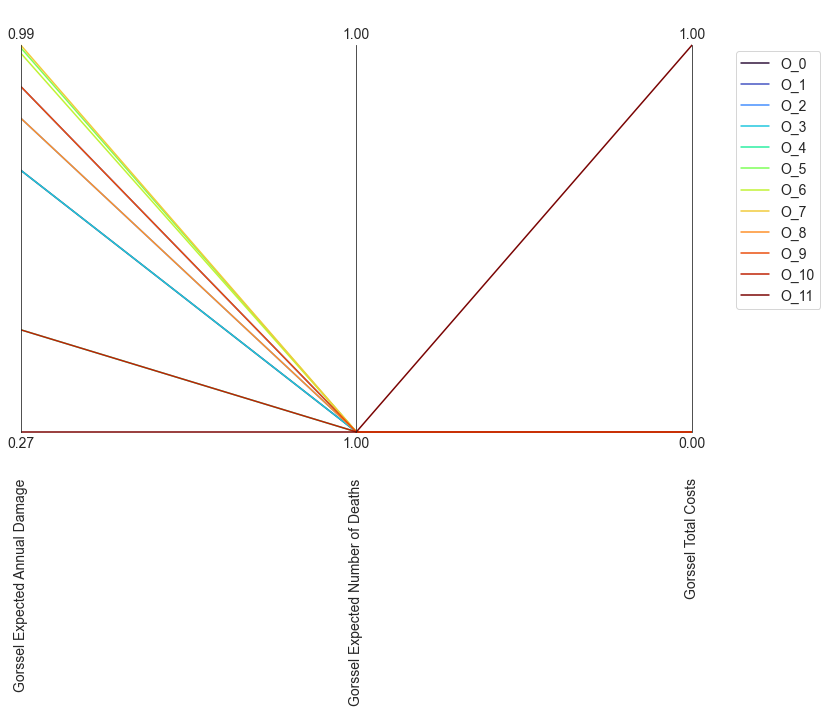

In [60]:
from matplotlib import cm

limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)


cmap = cm.get_cmap('turbo', overall_scores.shape[0])
i=0
for index, row in overall_scores.iterrows():
    name = 'O_' + str(i)
    paraxes.plot(row, color=cmap.colors[i], label=name)
    i+=1
    
paraxes.legend()
plt.savefig("../../report/figures/results/domain_criterion"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

In [26]:
overall_scores

,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs
scenario high option 0,0.757,1.0,0.0
scenario worst deaths option 8,0.913,1.0,0.0
scenario worst deaths option 7,0.854,1.0,0.0
scenario worst deaths option 5,0.757,1.0,0.0
scenario worst deaths option 3,0.460,1.0,0.0
scenario worst deaths option 0,0.985,1.0,0.0
scenario worst deaths option 4,0.975,1.0,0.0
scenario absolute worst option 4,0.990,1.0,0.0
scenario absolute worst option 5,0.854,1.0,0.0
scenario absolute worst option 1,0.913,1.0,0.0


## Scoring policies

### Normalise the regret and take the average to score the policies


In [27]:
from sklearn import preprocessing

In [28]:
#Normalize the regret results
regret_scores = maxregret.copy()
regret_average = regret_scores.apply(lambda x: x/x.max(), axis=0)


In [29]:
#Get the average for each policy
regret_average['average regret'] = regret_average.mean(numeric_only=True, axis=1)
regret_average.sort_values(by='average regret', ascending = False, inplace = True) #Lower = better
regret_average

,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs,average regret
policy,,,,
scenario worst deaths option 4,0.183447,1.000000,0.885327,0.689591
scenario absolute worst option 8,0.990143,0.272900,0.392379,0.551807
scenario worst deaths option 3,0.990143,0.272900,0.392379,0.551807
scenario high option 0,0.768139,0.287052,0.524766,0.526652
scenario worst deaths option 5,0.768139,0.222406,0.524766,0.505103
scenario absolute worst option 5,0.574618,0.254413,0.601853,0.476961
scenario worst deaths option 7,0.574618,0.254413,0.601853,0.476961
scenario worst deaths option 0,0.051899,0.291598,1.000000,0.447832
scenario absolute worst option 1,0.443379,0.202138,0.687121,0.444213


###  Use the satisficing / domain criterion and take their average to score the policies


In [30]:
#Get the average for each policy
satisficing_average = overall_scores.copy()
satisficing_average['average satisficing'] = satisficing_average.mean(numeric_only=True, axis=1)
satisficing_average.sort_values(by='average satisficing', ascending = True, inplace = True) #higher = better
satisficing_average

,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs,average satisficing
scenario worst deaths option 3,0.460,1.0,0.0,0.486667
scenario absolute worst option 8,0.460,1.0,0.0,0.486667
scenario high option 0,0.757,1.0,0.0,0.585667
scenario worst deaths option 5,0.757,1.0,0.0,0.585667
scenario worst deaths option 7,0.854,1.0,0.0,0.618000
scenario absolute worst option 5,0.854,1.0,0.0,0.618000
scenario worst deaths option 8,0.913,1.0,0.0,0.637667
scenario absolute worst option 1,0.913,1.0,0.0,0.637667
scenario worst deaths option 4,0.975,1.0,0.0,0.658333
scenario worst deaths option 0,0.985,1.0,0.0,0.661667


### Add them together  

In [31]:
merged_df = pd.concat([satisficing_average, regret_average], join="inner", axis = 1)


In [32]:
merged_df.sort_values(by='average satisficing', inplace = True, ascending = True)
merged_df.sort_values(by='average regret', inplace = True, ascending = False)




,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs,average satisficing,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs,average regret
scenario worst deaths option 4,0.975,1.0,0.0,0.658333,0.183447,1.000000,0.885327,0.689591
scenario worst deaths option 3,0.460,1.0,0.0,0.486667,0.990143,0.272900,0.392379,0.551807
scenario absolute worst option 8,0.460,1.0,0.0,0.486667,0.990143,0.272900,0.392379,0.551807
scenario high option 0,0.757,1.0,0.0,0.585667,0.768139,0.287052,0.524766,0.526652
scenario worst deaths option 5,0.757,1.0,0.0,0.585667,0.768139,0.222406,0.524766,0.505103
scenario worst deaths option 7,0.854,1.0,0.0,0.618000,0.574618,0.254413,0.601853,0.476961
scenario absolute worst option 5,0.854,1.0,0.0,0.618000,0.574618,0.254413,0.601853,0.476961
scenario worst deaths option 0,0.985,1.0,0.0,0.661667,0.051899,0.291598,1.000000,0.447832
scenario worst deaths option 8,0.913,1.0,0.0,0.637667,0.443379,0.202138,0.687121,0.444213
scenario absolute worst option 1,0.913,1.0,0.0,0.637667,0.443379,0.202138,0.687121,0.444213


In [33]:
#take te most robust policies and put them into a df.
robust_policies = merged_df.tail(5)
robust_policies

,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs,average satisficing,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs,average regret
scenario worst deaths option 0,0.985,1.0,0.0,0.661667,0.051899,0.291598,1.000000,0.447832
scenario worst deaths option 8,0.913,1.0,0.0,0.637667,0.443379,0.202138,0.687121,0.444213
scenario absolute worst option 1,0.913,1.0,0.0,0.637667,0.443379,0.202138,0.687121,0.444213
scenario absolute worst option 2,0.270,1.0,1.0,0.756667,1.000000,0.272900,0.000000,0.424300
scenario absolute worst option 4,0.990,1.0,0.0,0.663333,0.000000,0.000000,1.000000,0.333333


In [34]:
#now to return to an original list of policies with this
policy_names = robust_policies.index.values.tolist()

In [35]:
policy_names

['scenario worst deaths option 0',
 'scenario worst deaths option 8',
 'scenario absolute worst option 1',
 'scenario absolute worst option 2',
 'scenario absolute worst option 4']

In [36]:
temp_results = DU_policy_selected_df[DU_policy_selected_df['policy'].isin(policy_names)]

In [57]:
lever_names = policies_policy_df.columns.values.tolist()
lever_names

['3_RfR 0',
 '3_RfR 1',
 '3_RfR 2',
 '4_RfR 0',
 '4_RfR 1',
 '4_RfR 2',
 'EWS_DaysToThreat',
 'A.4_DikeIncrease 0',
 'A.4_DikeIncrease 1',
 'A.4_DikeIncrease 2',
 'A.5_DikeIncrease 0',
 'A.5_DikeIncrease 1',
 'A.5_DikeIncrease 2']

In [50]:
robust_policies_results = temp_results[lever_names].drop_duplicates()

In [54]:
robust_policies_results

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1000,0,0,0,1,1,1,2,5,0,0,3,4,1
5000,0,0,0,1,0,1,1,8,0,0,10,4,1
7000,0,0,0,1,1,1,3,8,0,0,2,5,3
9000,0,0,0,1,1,1,2,5,0,0,7,7,3
11000,0,0,0,1,1,1,3,0,0,0,4,3,7


In [55]:
robust_policies_results.to_csv('simulation/selected/selected_policies_' + ACTORNAME + '.csv')

In [58]:
lever_names.append('policy')
robust_policies_results_names = temp_results[lever_names].drop_duplicates()
robust_policies_results_names.set_index('policy', inplace = True)
robust_policies_results_names

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
policy,,,,,,,,,,,,,
scenario worst deaths option 8,0,0,0,1,1,1,2,5,0,0,3,4,1
scenario worst deaths option 0,0,0,0,1,0,1,1,8,0,0,10,4,1
scenario absolute worst option 4,0,0,0,1,1,1,3,8,0,0,2,5,3
scenario absolute worst option 1,0,0,0,1,1,1,2,5,0,0,7,7,3
scenario absolute worst option 2,0,0,0,1,1,1,3,0,0,0,4,3,7
